In [72]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [73]:
#join all streaming music history files to streaminghistory_df


df = pd.read_json('StreamingHistory_music_0.json')
df1 = pd.read_json('StreamingHistory_music_1.json')
df2 = pd.read_json('StreamingHistory_music_2.json')
df3 = pd.read_json('StreamingHistory_music_3.json')
df4 = pd.read_json('StreamingHistory_music_4.json')
df5 = pd.read_json('StreamingHistory_music_5.json')

streaminghistory_df = pd.concat([df, df1,df2,df3,df4,df5])  
streaminghistory_df.columns



Index(['endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object')

In [74]:
print(streaminghistory_df['endTime'].isnull().sum()) 
print(streaminghistory_df['endTime'].head())   
print(streaminghistory_df['endTime'].dtype) 


streaminghistory_df['endTime'] = streaminghistory_df['endTime'].astype(str)
streaminghistory_df['timestamp'] = pd.to_datetime(streaminghistory_df['endTime'])


0
0    2023-09-15 21:28
1    2023-09-16 00:30
2    2023-09-16 00:35
3    2023-09-16 00:38
4    2023-09-16 02:23
Name: endTime, dtype: object
object


In [75]:
streaminghistory_df.set_index('endTime', inplace=True)

#streaminghistory_df['endTime']

In [76]:
daily_listens = streaminghistory_df.groupby(streaminghistory_df['timestamp'].dt.date).size()
daily_listens




timestamp
2023-09-15      1
2023-09-16    118
2023-09-17     49
2023-09-18    122
2023-09-19     58
             ... 
2024-09-12    175
2024-09-13    123
2024-09-14    104
2024-09-15    163
2024-09-16    136
Length: 368, dtype: int64

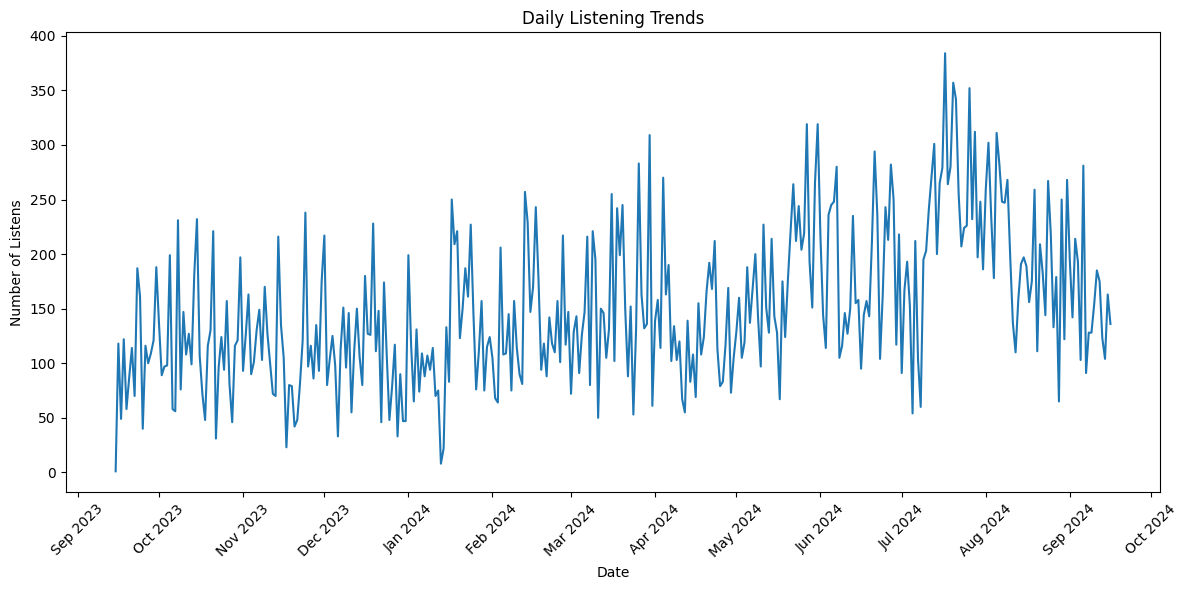

In [77]:
# Plot the daily listens
plt.figure(figsize=(12, 6))
plt.plot(daily_listens.index, daily_listens.values)

# Set x-axis major ticks to the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))

# Format the ticks to show the date in 'MMM YYYY' format (e.g., Jan 2024)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate the labels for better readability
plt.xticks(rotation=45)

# Set title and labels
plt.title('Daily Listening Trends')
plt.xlabel('Date')
plt.ylabel('Number of Listens')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

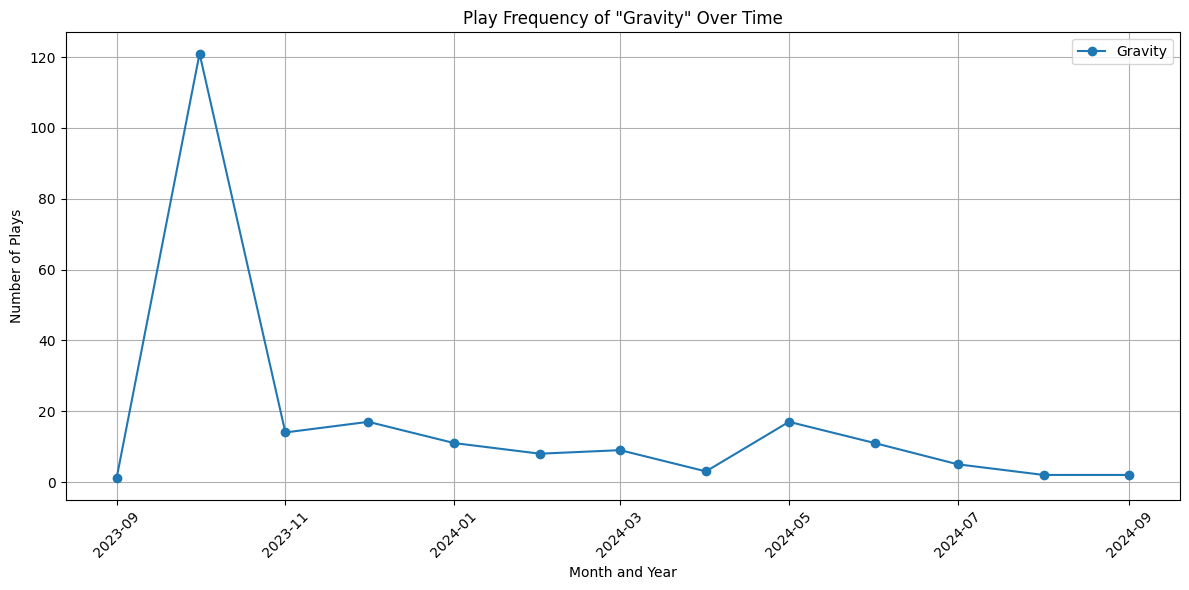

In [78]:
# 1. Convert 'endTime' to datetime
#streaminghistory_df['endTime'] = pd.to_datetime(streaminghistory_df['endTime'])


# 2. Extract the month and year from the 'endTime' column
streaminghistory_df['month_year'] = streaminghistory_df['timestamp'].dt.to_period('M')  # Extract month and year

# 3. Group by 'trackName' and 'month_year' to count the number of plays
track_popularity = streaminghistory_df.groupby(['trackName', 'month_year']).size().reset_index(name='play_count')

# 4. Choose a specific track to analyze (replace 'Your Track Name' with the actual track name)
specific_track = 'Gravity'  # Change this to the track you want to analyze

# Filter for the specific track
track_data = track_popularity[track_popularity['trackName'] == specific_track]

# 5. Plot the data
plt.figure(figsize=(12, 6))
plt.plot(track_data['month_year'].dt.to_timestamp(), track_data['play_count'], marker='o', label=specific_track)
plt.title(f'Play Frequency of "{specific_track}" Over Time')
plt.xlabel('Month and Year')
plt.ylabel('Number of Plays')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

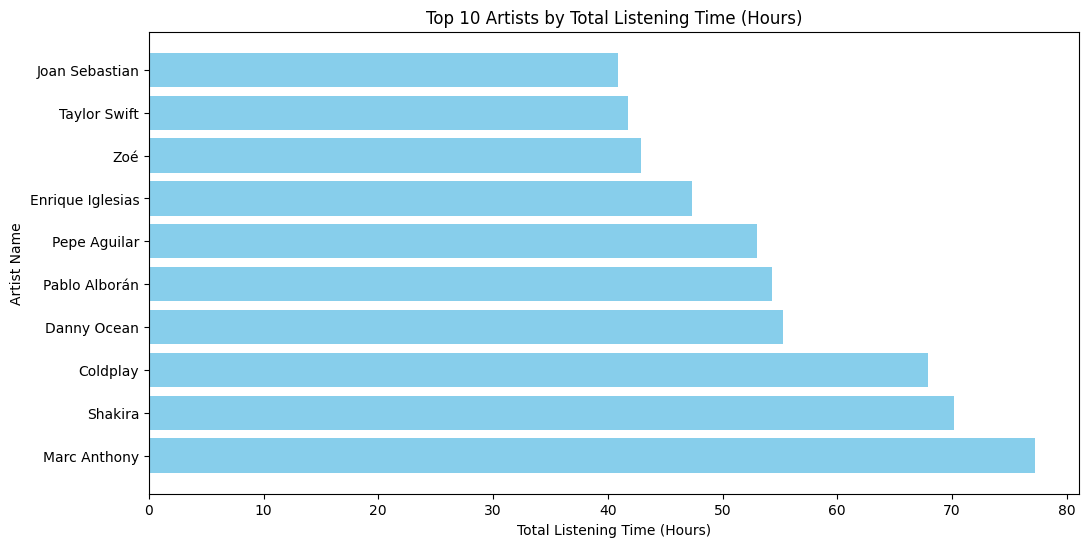

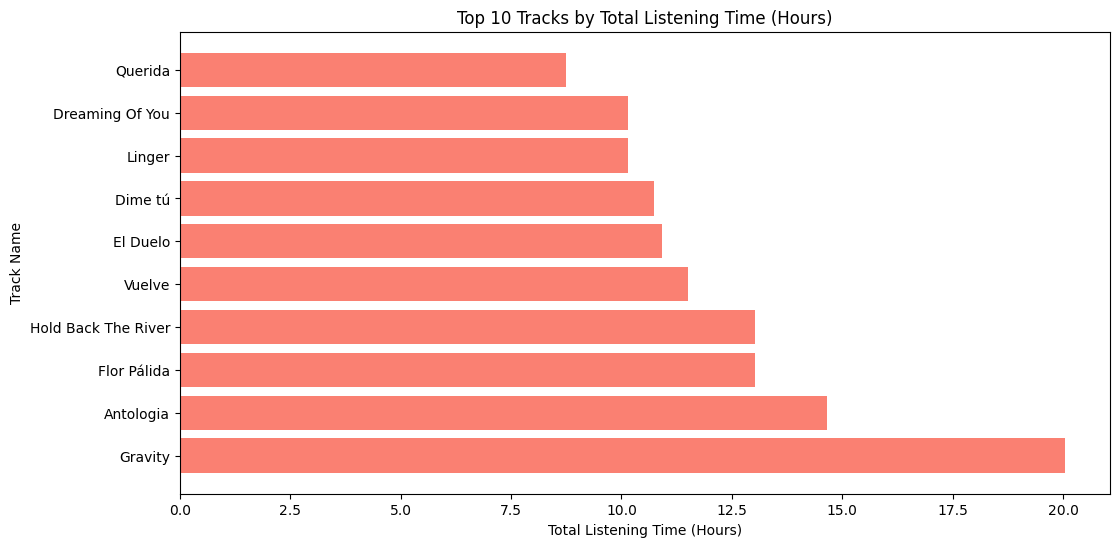

In [79]:
# 1. Group by artist and calculate total listening time in hours
artist_listening = streaminghistory_df.groupby('artistName')['msPlayed'].sum().reset_index()
artist_listening['hoursPlayed'] = artist_listening['msPlayed'] / (1000 * 60 * 60)  # Convert ms to hours

# 2. Sort the results to find the top artists
top_artists = artist_listening.sort_values(by='hoursPlayed', ascending=False).head(10)

# 3. Group by track and calculate total listening time in hours
track_listening = streaminghistory_df.groupby('trackName')['msPlayed'].sum().reset_index()
track_listening['hoursPlayed'] = track_listening['msPlayed'] / (1000 * 60 * 60)  # Convert ms to hours

# 4. Sort the results to find the top tracks
top_tracks = track_listening.sort_values(by='hoursPlayed', ascending=False).head(10)

# 5. Plotting the Top Artists
plt.figure(figsize=(12, 6))
plt.barh(top_artists['artistName'], top_artists['hoursPlayed'], color='skyblue')
plt.title('Top 10 Artists by Total Listening Time (Hours)')
plt.xlabel('Total Listening Time (Hours)')
plt.ylabel('Artist Name')
plt.show()

# 6. Plotting the Top Tracks
plt.figure(figsize=(12, 6))
plt.barh(top_tracks['trackName'], top_tracks['hoursPlayed'], color='salmon')
plt.title('Top 10 Tracks by Total Listening Time (Hours)')
plt.xlabel('Total Listening Time (Hours)')
plt.ylabel('Track Name')
plt.show()

Total tracks: 55381
Skipped tracks: 16744
Percentage of tracks skipped: 30.23%


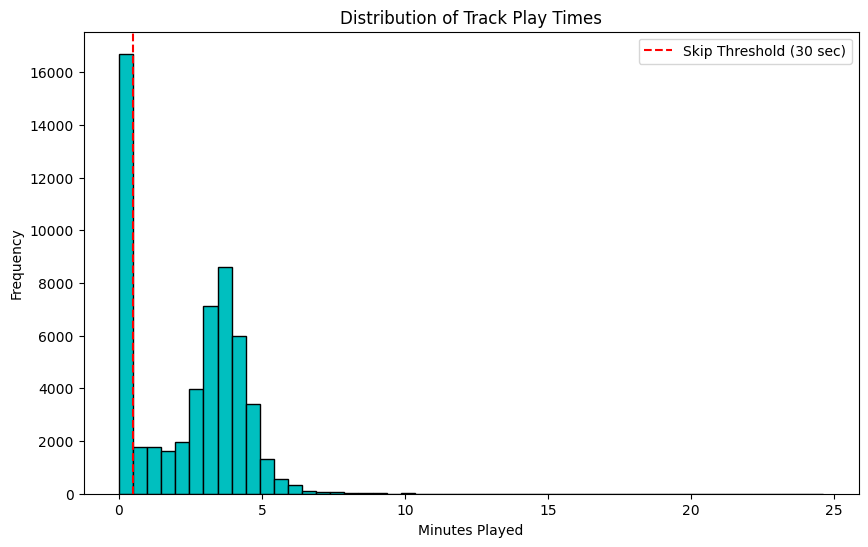

In [80]:
## Calculate Skip percentage/likelyhood

#Calculate average play time (ms) and convert ms to minutes for readability
streaminghistory_df['minutesPlayed'] = streaminghistory_df['msPlayed'] / (1000 * 60)

# 2. Analyze potential skipping behavior
# Set a threshold: if a track was played less than 30 seconds, it could be considered as skipped
skip_threshold = 30 / 60  # Convert 30 seconds to minutes

# Add a new column to flag if the track is likely skipped
streaminghistory_df['skipped'] = streaminghistory_df['minutesPlayed'] < skip_threshold

# 3. Calculate the percentage of skipped tracks
total_tracks = len(streaminghistory_df)
skipped_tracks = streaminghistory_df['skipped'].sum()
percent_skipped = (skipped_tracks / total_tracks) * 100

print(f"Total tracks: {total_tracks}")
print(f"Skipped tracks: {skipped_tracks}")
print(f"Percentage of tracks skipped: {percent_skipped:.2f}%")

# 4. Plot the distribution of playback times
plt.figure(figsize=(10, 6))
plt.hist(streaminghistory_df['minutesPlayed'], bins=50, color='c', edgecolor='black')
plt.axvline(skip_threshold, color='r', linestyle='--', label='Skip Threshold (30 sec)')
plt.title('Distribution of Track Play Times')
plt.xlabel('Minutes Played')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [81]:
import json
import pandas as pd

# Load the JSON file
with open('YourLibrary.json') as f:
    data = json.load(f)

# Inspect the keys
print(data.keys())

# Assuming 'tracks' or a similar key contains the data you want
key_name = 'tracks'  # Replace with the actual key from your JSON

# Check if the key exists and contains a list
if key_name in data and isinstance(data[key_name], list):
    # Convert to DataFrame
    df = pd.DataFrame(data[key_name])
    print(df.head())  # Display the first few rows
else:
    print(f"Data under '{key_name}' is not a list or key doesn't exist.")

dict_keys(['tracks', 'albums', 'shows', 'episodes', 'bannedTracks', 'artists', 'bannedArtists', 'other'])
               artist          album                            track  \
0  Conjunto Primavera      Decide Tú                   Vuelve Conmigo   
1                Reik          Ciego                            Ciego   
2         Playa Limbo          Creer                            Creer   
3          Dean Lewis  Looks Like Me                    Looks Like Me   
4         Glass Tiger       Air Time  Don't Forget Me (When I'm Gone)   

                                    uri  
0  spotify:track:6RIxa9MZvemFe89YAZGD2J  
1  spotify:track:5vNocq26ujTMI4L8bECuGk  
2  spotify:track:6bhFOmcFhcrMWtD00cWcWq  
3  spotify:track:6o8tRLnKNSVoBHCTfiFdBA  
4  spotify:track:1cX89LkWJoJPS8uJFpqkIp  


In [82]:
df

,artist,album,track,uri
0,Conjunto Primavera,Decide Tú,Vuelve Conmigo,spotify:track:6RIxa9MZvemFe89YAZGD2J
1,Reik,Ciego,Ciego,spotify:track:5vNocq26ujTMI4L8bECuGk
2,Playa Limbo,Creer,Creer,spotify:track:6bhFOmcFhcrMWtD00cWcWq
3,Dean Lewis,Looks Like Me,Looks Like Me,spotify:track:6o8tRLnKNSVoBHCTfiFdBA
4,Glass Tiger,Air Time,Don't Forget Me (When I'm Gone),spotify:track:1cX89LkWJoJPS8uJFpqkIp
...,...,...,...,...
2193,Jennifer Rush,80s 100 Hits,The Power of Love - Radio Edit,spotify:track:2lfuRFfpU0IbMx0QuRtE0i
2194,Jason Mraz,Love Is a Four Letter Word,93 Million Miles,spotify:track:1s8tP3jP4GZcyHDsjvw218
2195,Pedro Fernández,Mi Forma De Sentir,Mi Forma De Sentir,spotify:track:5lgpyVntKs6yFvzSvbMJff
2196,Zoé,MTV Unplugged Música De Fondo,Luna - En Vivo,spotify:track:7b3k8I1fncAzbk9PHnLkbX


Files:
    Marquee.json: 1542 X 2. Highlights Artists and segment
    StreamingHistory_music...: contains all listened to music with ms played as well as timestamp.